In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
DEBUG_ON = False

In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [6]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [7]:
def readLangs(lang1, lang2, reverse=False):
    print('Reading lines...')
    
    lines = open('data/data/{}-{}.txt'.format(lang1, lang2), encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH and \
           p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print('Read {} sentence paris'.format(len(pairs)))
    pairs = filterPairs(pairs)
    print('Trimmed to {} sentence pairs'.format(len(pairs)))
    print('Counting words...')
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print('Counted words: ')
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [10]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence paris
Trimmed to 10599 sentence pairs
Counting words...
Counted words: 
fra 4345
eng 2803
['j achete des fruits et du chocolat .', 'i m buying fruit and chocolate .']


In [11]:
class EncoderRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        if DEBUG_ON:
            print(f'encoder intput: {input}')
            print(f'just self.embedding(input): {self.embedding(input)}')
        embedded = self.embedding(input).view(1, 1, -1)
        if DEBUG_ON:
            print(f'embedded: {embedded}')
            
        output = embedded
        output, hidden = self.gru(output, hidden)
        
        if DEBUG_ON:
            print(f'output: {output}, \nhidden: {hidden}')
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [12]:
class AttnDecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        if DEBUG_ON:
            print(f'decoder input: {input}')
            print(f'hidden: {hidden}')
            print(f'encoder_outputs: {encoder_outputs}')
            print(f'just self.embedding(input): {self.embedding(input)}')
        embedded = self.embedding(input).view(1, 1, -1)
        if DEBUG_ON:
            print(f'embedded: {embedded}')
        embedded = self.dropout(embedded)
        if DEBUG_ON:
            print(f'embed dropout: {embedded}')
            print(f'torch.cat((embedded[0], hidden[0]), 1): {torch.cat((embedded[0], hidden[0]), 1)}')
            
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        if DEBUG_ON:
            print(f'attn_weights: {attn_weights}, \nattn_applied: {attn_applied}')
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        if DEBUG_ON:
            print(f'out1: {output}')
        output = self.attn_combine(output).unsqueeze(0)
        if DEBUG_ON:
            print(f'out2: {output}')
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        if DEBUG_ON:
            print(f'out3: {output}')
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [14]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            if DEBUG_ON:
                print(f'decoder_output: {decoder_output}, \ntarget_tensor: {target_tensor[di]}')
                
            decoder_input = target_tensor[di]
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
                
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

In [15]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        if DEBUG_ON:
            print(f'input_tensor: {input_tensor}, \ntarget_tensor: {target_tensor}')
        
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            
            print('{} ({} {}%) {:.4f}'.format(timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))
        
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
        if DEBUG_ON:
            break
            
    showPlot(plot_losses)

In [17]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [20]:
if DEBUG_ON:
    hidden_size = 6
else:
    hidden_size = 256

encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

# print(input_lang.n_words, output_lang.n_words)
trainIters(encoder1, attn_decoder1, 10000, print_every=100)

0m 2s (- 3m 45s) (100 1.0%) 4.2071
0m 4s (- 3m 36s) (200 2.0%) 3.5506
0m 6s (- 3m 36s) (300 3.0%) 3.5192
0m 8s (- 3m 34s) (400 4.0%) 3.3461
0m 11s (- 3m 33s) (500 5.0%) 3.4071
0m 13s (- 3m 33s) (600 6.0%) 3.3828
0m 15s (- 3m 32s) (700 7.000000000000001%) 3.3573
0m 18s (- 3m 29s) (800 8.0%) 3.2379
0m 20s (- 3m 28s) (900 9.0%) 3.3648
0m 22s (- 3m 25s) (1000 10.0%) 3.1913
0m 25s (- 3m 22s) (1100 11.0%) 3.2049
0m 27s (- 3m 20s) (1200 12.0%) 3.1027
0m 29s (- 3m 18s) (1300 13.0%) 3.0602
0m 31s (- 3m 16s) (1400 14.000000000000002%) 2.9864
0m 34s (- 3m 14s) (1500 15.0%) 2.9081
0m 36s (- 3m 12s) (1600 16.0%) 2.8221
0m 38s (- 3m 9s) (1700 17.0%) 2.9440
0m 41s (- 3m 7s) (1800 18.0%) 3.0616
0m 43s (- 3m 5s) (1900 19.0%) 2.7613
0m 45s (- 3m 3s) (2000 20.0%) 2.8379
0m 48s (- 3m 1s) (2100 21.0%) 2.9855
0m 50s (- 2m 59s) (2200 22.0%) 2.5942
0m 52s (- 2m 57s) (2300 23.0%) 2.9877
0m 55s (- 2m 54s) (2400 24.0%) 2.7564
0m 57s (- 2m 52s) (2500 25.0%) 2.8943
0m 59s (- 2m 50s) (2600 26.0%) 2.6499
1m 2s (- 2m

In [21]:
evaluateRandomly(encoder1, attn_decoder1)

> je ne suis pas embarrasse .
= i m not embarrassed .
< i m not certain . <EOS>

> tu prevois toujours des problemes .
= you re always anticipating trouble .
< you re going to my . . <EOS>

> la moisson s annonce bonne cette annee .
= we re expecting a good harvest this year .
< i m a good at the . . <EOS>

> je suis trop fatigue pour courir .
= i am too tired to run .
< i m too tired to my . . <EOS>

> elle est de mauvaise humeur .
= she is in a bad mood .
< she is a good . . <EOS>

> nous sommes separes .
= we re separated .
< we re early . <EOS>

> elles sont trop grosses .
= they re too fat .
< they re too . . <EOS>

> il projette de lancer son entreprise .
= he is planning to launch his business .
< he is afraid of my job . <EOS>

> je commence a sentir que quelque chose deconne .
= i m beginning to smell a rat .
< i m afraid i am . <EOS>

> elles sont juste pour toi .
= they re just for you .
< they re about you . <EOS>



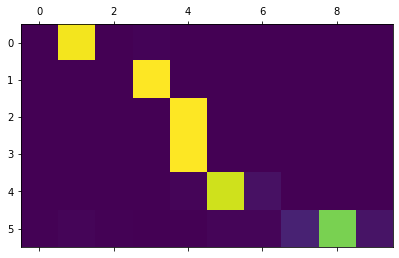

In [23]:
%matplotlib inline

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())


input = elle a cinq ans de moins que moi .
output = she is always years than i am . <EOS>


/var/folders/g2/jy_8z3fs28526pxbf3l1gbdm0000gn/T/ipykernel_10580/744067545.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/g2/jy_8z3fs28526pxbf3l1gbdm0000gn/T/ipykernel_10580/744067545.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


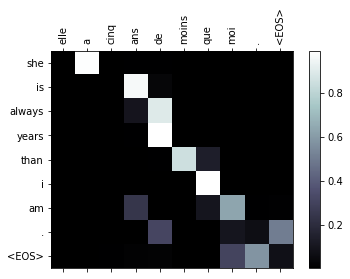

input = elle est trop petit .
output = she is too busy . <EOS>


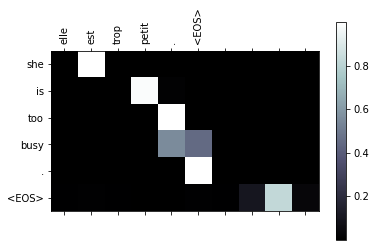

input = je ne crains pas de mourir .
output = i m not going to <EOS>


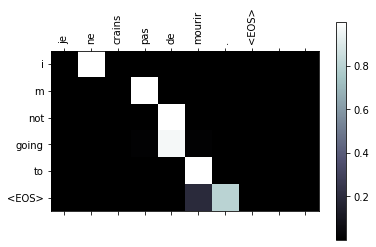

input = c est un jeune directeur plein de talent .
output = he is a good man . <EOS>


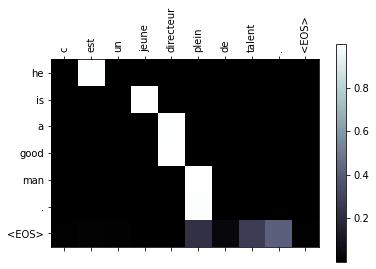

In [24]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")